In [42]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()


# questions:
- statistclally sound to drop


In [43]:
df = pd.read_csv('/Users/sanyakhan/Downloads/df_dropped_rows.csv')
df2 = pd.read_csv('/Users/sanyakhan/Downloads/df_dropped_rows_w_statepartyna.csv')
df_unique = df2.drop_duplicates(subset=["Title"]).reset_index(drop=True)


In [44]:
#include in slides t oa sk 
len(df['Title'].value_counts()), len(df2['Title'].value_counts())

(1342, 1433)

In [ ]:
custom_stopwords = [ "agency",
"the","a","an","and","or","if","of","for","in","on","at","by","to","from","with", "people", "state", "want", "going",
"is","are","was","were","be","been","being","as","it","its","this","that","these","those",
"i","me","my","we","our","you","your","he","she","they","them","their","his","her",
"not","but","do","does","did","so","because","can","could","should","would","will","may","might",
"also","just","very","much","more","such","than","then","there","here","when","where","who","what","which","how",
"all","any","each","every","some","no","nor","only","own","same","too","into","up","down","about","over","under",
"thank","thankyou","yield","gentleman","gentlewoman","chair","chairman","chairwoman","speaker","presiding",
"recognize","recognized","recognition","remarks","floor","colleague","colleagues","proceed","order","ordered",
"committee","subcommittee","motion","unanimous","consent","debate","amendment","amend","section","title",
"chapter","paragraph","subparagraph","clause","statutory","herein","whereas","therefore","resolved","pursuant",
"enact","enacted","mr","mrs","ms","madam","sir","act","bill","resolution","senate","house","representative",
"representatives","congress","member","members","session","hearing","witness","testimony","law","legislation",
"legislative","vote","enactment","proceedings","statute","appropriation","federal","agency","program",
"department","secretary","policy","administration","executive","authority","director","office","ranking",
"majority","minority","sec","subsec","subtitle","appendix","figure","table","page","pages","line","lines",
"insert","strike","sentence","word","words","heading","part","division","codified","usc","code","public","law",
"number","numbers","date","dates","document","doc","clerk","shall","must","make","made","makes","take","taken",
"took","get","got","getting","give","gave","let","say","said","says","see","seen","look","looked","know","known",
"think","thought","myself","ours","ourselves","your","yours","yourself","yourselves","him","his","himself",
"hers","herself","theirs","themselves","itself","one","ones","someone","anyone","everyone","noone","many",
"much","none","both","either","neither","while","though","although","however","therefore","through","across",
"around","between","within","without","such","as","now","today","time","times","year","years","day","days",
"long","short","new","old","first","second","third","next","last","us","including","need","percent","miss",
"dr","chairperson","president","gentlelady","gentlemen","lady","panel","rules","rule","laws","policies",
"reading","read","united","states","america","american","washington","dc","bureau","tomorrow","week","body","week", "gentlewoman","body","floor","colleague","colleagues", 'move', 'congressional', 'record', 'vol', "appropriation"


BIGRAM_PAIRS = {
    ("affordable","housing"),
    ("domestic","violence"),
    ("mental","health"),
    ("chronic","homelessness"),
    ("emergency","shelter"),
    ("permanent","supportive"),
    ("rapid","rehousing"),
    ("veteran","homeless"),
    ("veterans","homeless"),
    ("people","experiencing"), 
    ("experiencing","homelessness"),
    ("unsheltered","homelessness"),
    ("supportive","housing"),
    ("substance","abuse"),
    ("housing","first"),
    ("youth","homelessness"),
}


STOP = set(stopwords.words("english"))
WORD = re.compile(r"[A-Za-z]+")
STOP.update(custom_stopwords)

In [ ]:
def get_tokens(text):
    toks = []
    for w in WORD.findall(text):
        w = w.lower()
        if w and len(w) > 1 and w not in STOP:
            w = lem.lemmatize(w)       
            toks.append(w)

    bigrams = []
    for i in range(len(toks) - 1):
        pair = (toks[i], toks[i + 1])
        if pair in BIGRAM_PAIRS:
            bigrams.append(f"{pair[0]}_{pair[1]}")

    return toks + bigrams

#adds doc_id so we can rejoin later
df = df.assign(id=lambda d: d.index)
df_unique = df_unique.assign(id=lambda d:d.index)
df["tokens_speech_text"] = df["speech_text"].map(get_tokens) 
df_unique["tokens_act_text"] = df_unique["Title"].map(get_tokens) 

# explode to long form keep, each row is now single token
tokens_speech = (
    df[["id", "Party", "Year", "Title", "tokens_speech_text"]]  
    .explode("tokens_speech_text")
    .dropna(subset=["tokens_speech_text"])
)


tokens_act = (df_unique[["id","Year","tokens_act_text"]]
          .explode("tokens_act_text")
          .rename(columns={"tokens_act":"tokens_act_text"})
          .dropna(subset=["tokens_act_text"]))
tokens_act.head(10)
tokens_speech.head(10)

,id,Party,Year,Title,tokens_speech_text
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,suspend
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,pas
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,housing
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,exclude
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,certain
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,disability
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,benefit
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,income
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,purpose
0,0,Republican,2025,HOUSING UNHOUSED DISABLED VETERANS ACT; Congre...,determining


In [47]:
#my first appraoch was to just look at words from a bag of words perspective
#most used words overall
top_words_speech = (
    tokens_speech["tokens_speech_text"]
    .value_counts()
    .head(100)
    .reset_index()
    .rename(columns={"index": "token", "token": "frequency"})
)
pd.set_option("display.max_rows", None)
top_words_speech.head(25)

norm = (
    tokens_act["tokens_act_text"]
    .astype(str)
    .str.normalize("NFKC")                    
    .str.lower()
    .str.replace(r"[^\w\s]", " ", regex=True) 
    .str.replace(r"\s+", " ", regex=True)    
    .str.strip()
)
custom_stopwords_norm = { 
    s.lower().strip() for s in custom_stopwords
}

tokens_act = tokens_act.assign(tokens_act_text=norm)

tokens_act = tokens_act[
    tokens_act["tokens_act_text"].str.len().ge(2) &
    ~tokens_act["tokens_act_text"].str.fullmatch(r"\d+") &
    ~tokens_act["tokens_act_text"].isin(custom_stopwords_norm)
]

top_words_act = (
    tokens_act["tokens_act_text"].value_counts()
    .head(100)
    .rename_axis("token").reset_index(name="count")
)

top_words_act = (
    tokens_act["tokens_act_text"]
    .value_counts()
    .head(100)
    .reset_index()
    .rename(columns={"index": "token", "token": "frequency"})
)
pd.set_option("display.max_rows", None)
top_words_act.head(10)

,tokens_act_text,count
0,veteran,216
1,providing,157
2,consideration,151
3,housing,147
4,related,145
5,health,126
6,development,108
7,affair,97
8,report,94
9,defense,93


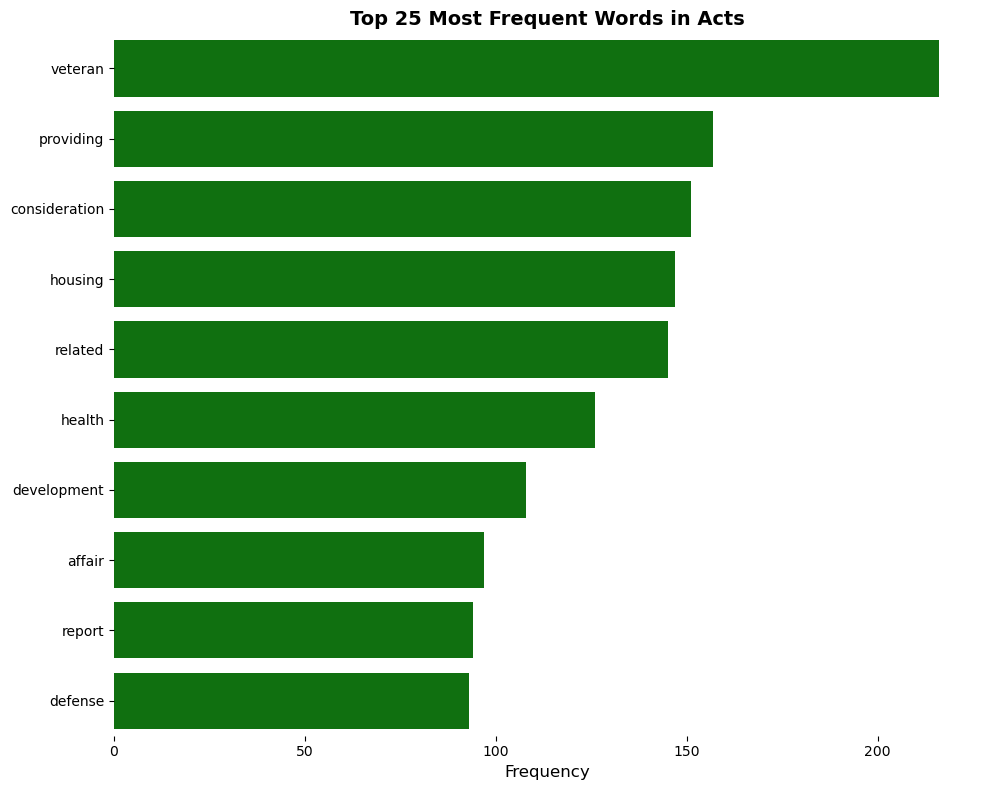

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_words_act.head(10),
    y="tokens_act_text", 
    x="count",
    color="green"  
)

plt.title("Top 25 Most Frequent Words in Acts", fontsize=14, weight='bold')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("")
plt.grid(False)
sns.despine(left=True, bottom=True) 
plt.tight_layout()
plt.show()

In [49]:
top_speech_by_party = (
    tokens_speech
    .groupby("Party")["tokens_speech_text"]
    .value_counts()
    .groupby(level=0, group_keys=False)
    .head(100)
    .reset_index(name="count")
)
top_speech_by_party_D = top_speech_by_party[top_speech_by_party["Party"] == "Democrat"].reset_index(drop=True)
top_speech_by_party_R = top_speech_by_party[top_speech_by_party["Party"] == "Republican"].reset_index(drop=True)

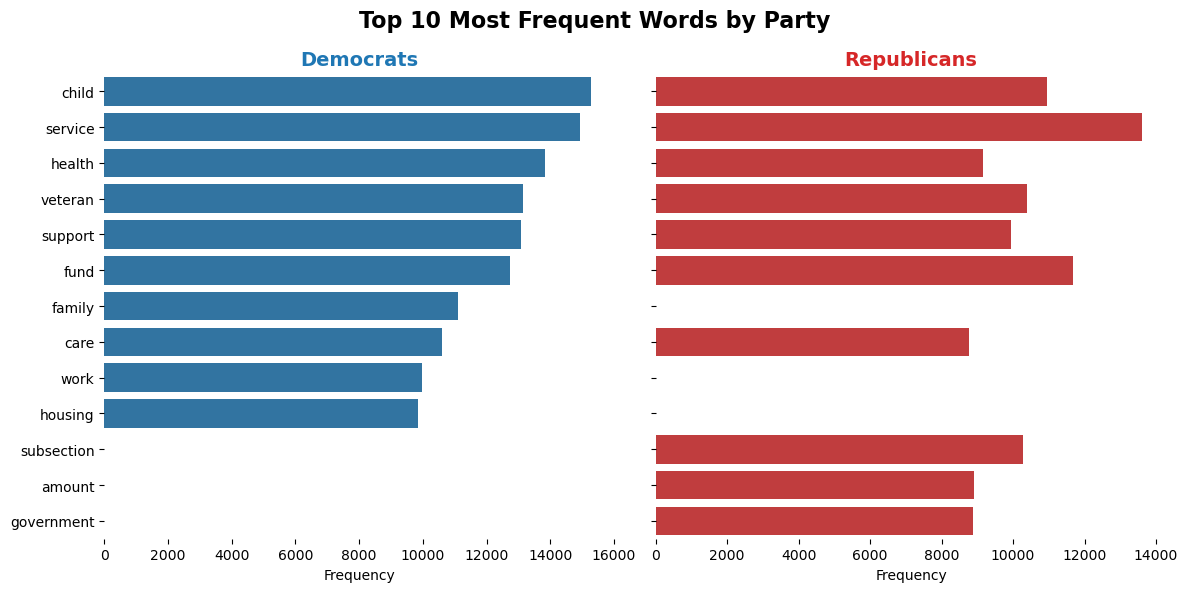

In [50]:
d10 = top_speech_by_party_D.head(10)
r10 = top_speech_by_party_R.head(10)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.barplot(
    data=d10,
    x="count", y="tokens_speech_text",
    color="#1f77b4", ax=axes[0]
)
axes[0].set_title("Democrats", fontsize=14, weight="bold", color="#1f77b4")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("")
sns.despine(ax=axes[0], left=True, bottom=True)
axes[0].grid(False)

sns.barplot(
    data=r10,
    x="count", y="tokens_speech_text",
    color="#d62728", ax=axes[1]
)
axes[1].set_title("Republicans", fontsize=14, weight="bold", color="#d62728")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("")
sns.despine(ax=axes[1], left=True, bottom=True)
axes[1].grid(False)

plt.suptitle("Top 10 Most Frequent Words by Party", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

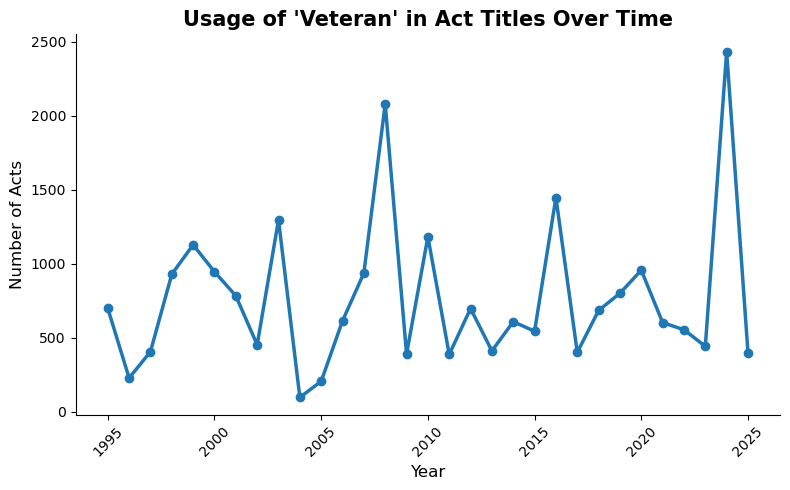

In [ ]:
#maybe delete 2025 bc it looks like a drop 

veteran_df = tokens_speech[tokens_speech["tokens_speech_text"].str.contains("veteran", case=False, na=False)]

veteran_counts = (
    veteran_df.groupby("Year")
    .size()
    .reset_index(name="count")
    .sort_values("Year")
)
plt.figure(figsize=(8, 5))

plt.plot(
    veteran_counts["Year"],
    veteran_counts["count"],
    color="#1f77b4",     
    linewidth=2.5,
    marker="o"
)

plt.title("Usage of 'Veteran' in Act Titles Over Time", fontsize=15, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Acts", fontsize=12)
plt.xticks(rotation=45)
plt.grid(False)        
sns.despine()    
plt.tight_layout()
plt.show()



In [52]:

keywords_all = [
    "homeless", "houseless", "unsheltered", "unhoused", "vagrant", "tramp",
    "people_experiencing", "experiencing_homelessness", "chronic_homelessness",
    "housing", "affordable", "supportive_housing", "rehousing", 
    "rapid_rehousing", "permanent_supportive", "eviction", "shelter",
    "emergency_shelter",
    "veteran", "veterans_homeless", "veteran_homeless", "elderly", "youth",
    "drugs", "addiction", "substance", "mental_health", 
    "substance_abuse", "criminal", "criminality", "violent",
    "encampment", "trespassing", "cleanup",
    "domestic", "domestic_violence", "poverty", "unemployment",
    "joblessness", "foreclosure", "gentrification", "eviction"

]

for_homelessness = [
        "homeless", "houseless", "unsheltered" "unhoused", "vagrant", "tramp",
        "people_experiencing", "experiencing_homelessness",
        "chronic_homelessness"]

housing_related = [
        "housing", "affordable", "supportive_housing", "rehousing", 
        "rapid_rehousing", "permanent_supportive", "eviction", "shelter",
        "emergency_shelter"],

population = [
        "veteran", "veterans_homeless", "veteran_homeless", "elderly", "youth"
    ]

behavioral_health = ["drugs", "addiction", "substance", "mental_health", "substance_abuse", "criminal", "criminality", "violent"]
policy_enforcement  = ["encampment", "trespassing", "cleanup"]
situational_terms  = ["domestic", "domestic_violence", 'poverty', 'unemployment', 'joblessness', 'foreclosure', 'gentrification', 'evicition']




keyword_speech = tokens_speech[tokens_speech["tokens_speech_text"].isin(keywords_all)]

keyword_speech_counts = (
    keyword_speech.groupby("tokens_speech_text")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
keyword_speech_counts


,tokens_speech_text,count
33,veteran,23600
16,housing,18630
15,homeless,3718
6,domestic,3087
36,youth,2901
18,mental_health,2676
1,affordable,2488
24,substance,2144
4,criminal,2131
29,unemployment,1967


In [53]:
#sibcategories need refinement 

for_homelessness = [
    "homeless", "houseless", "unsheltered", "unhoused", "vagrant", "tramp",
    "people_experiencing", "experiencing_homelessness", "chronic_homelessness"
]

housing_related = [
    "housing", "affordable", "supportive_housing", "rehousing", 
    "rapid_rehousing", "permanent_supportive", "eviction", "shelter",
    "emergency_shelter"
]

population = [ #need more on this domian knowlefe 
    "veteran","veteran_homeless", "elderly", "youth"
]

behavioral_health = [
    "drugs", "addiction", "substance", "mental_health",
    "substance_abuse", "criminal", "criminality", "violent"
]

policy_enforcement = ["encampment", "trespassing", "cleanup"]

situational_terms = [
    "domestic", "domestic_violence", "poverty", "unemployment",
    "joblessness", "foreclosure", "gentrification", "eviction"
]

keywords_all = (
    for_homelessness +housing_related + population +behavioral_health +policy_enforcement + situational_terms
)

category_map = {}
for word in for_homelessness:
    category_map[word] = "for_homelessness"
for word in housing_related:
    category_map[word] = "housing_related"
for word in population:
    category_map[word] = "population"
for word in behavioral_health:
    category_map[word] = "behavioral_health"
for word in policy_enforcement:
    category_map[word] = "policy_enforcement"
for word in situational_terms:
    category_map[word] = "situational_terms"

keyword_speech = tokens_speech[tokens_speech["tokens_speech_text"].isin(keywords_all)].copy()

keyword_speech["keyword_category"] = keyword_speech["tokens_speech_text"].map(category_map)

keyword_speech_counts = (
    keyword_speech.groupby(["keyword_category", "tokens_speech_text"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

keyword_speech_counts


,keyword_category,tokens_speech_text,count
26,population,veteran,23600
16,housing_related,housing,18630
9,for_homelessness,homeless,3718
29,situational_terms,domestic,3087
28,population,youth,2901
3,behavioral_health,mental_health,2676
14,housing_related,affordable,2488
4,behavioral_health,substance,2144
1,behavioral_health,criminal,2131
36,situational_terms,unemployment,1967


In [54]:
keyword_category_counts = (
    keyword_speech_counts
    .groupby("keyword_category")["count"]
    .sum()
    .reset_index()
    .sort_values("count", ascending=False)
)
overall_total = keyword_category_counts["count"].sum()
overall_total
print(keyword_category_counts)


     keyword_category  count
4          population  27819
2     housing_related  22441
5   situational_terms   9765
0   behavioral_health   9205
1    for_homelessness   3869
3  policy_enforcement    547


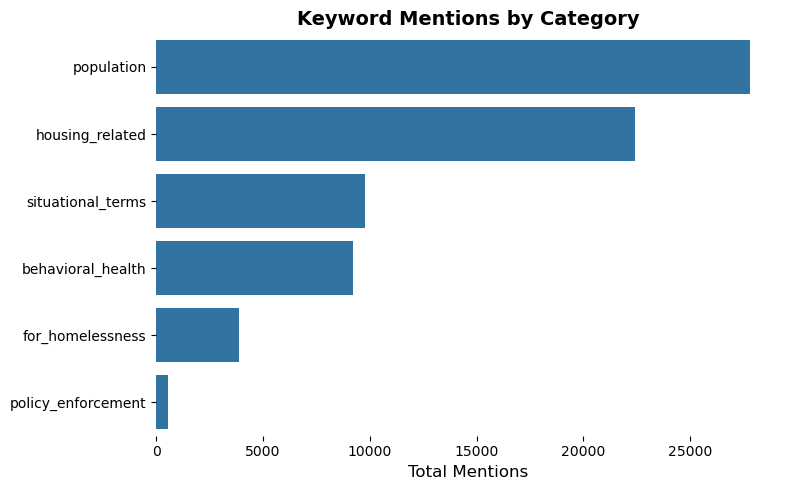

In [ ]:

plt.figure(figsize=(8, 5))
sns.barplot(
    data=keyword_category_counts,
    x="count",
    y="keyword_category",
    color="#1f77b4",
    order=keyword_category_counts.sort_values("count", ascending=False)["keyword_category"]
)

plt.title("Keyword Mentions by Category", fontsize=14, weight="bold")
plt.xlabel("Total Mentions", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()

Party               Democrat  Republican
keyword_category                        
population             15361       12387
housing_related        12296       10062
situational_terms       6288        3450
behavioral_health       5203        3995
for_homelessness        2459        1403
policy_enforcement       343         199


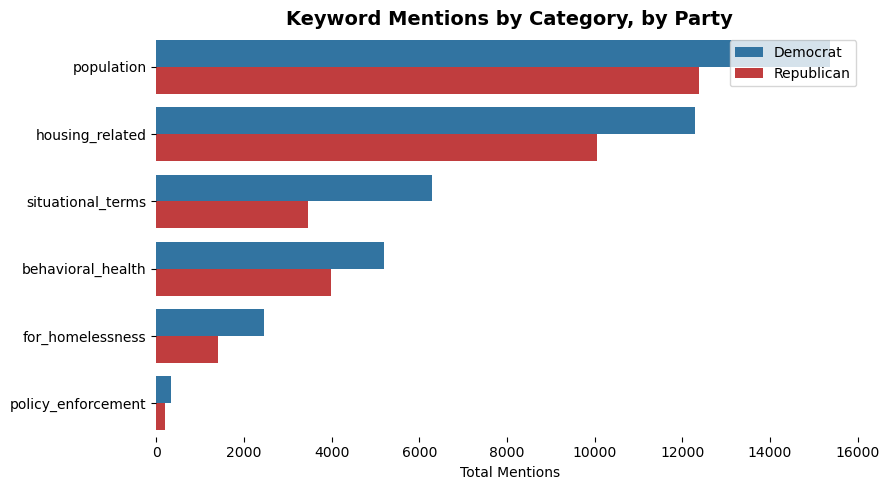

In [56]:
byparty = keyword_speech[keyword_speech["Party"].isin(["Democrat", "Republican"])].copy()
party_category_counts = (
    byparty.groupby(["Party", "keyword_category"])
    .size()
    .reset_index(name="count")
)

order = (party_category_counts
         .groupby("keyword_category")["count"].sum()
         .sort_values(ascending=False)
         .index)
party_category_pivot = (
    party_category_counts
    .pivot(index="keyword_category", columns="Party", values="count")
    .fillna(0).astype(int)
    .loc[order]
)
print(party_category_pivot)
plt.figure(figsize=(9, 5))
sns.barplot(
    data=party_category_counts,
    x="count", y="keyword_category",
    hue="Party",
    order=order,
    palette=["#1f77b4", "#d62728"]
)
plt.title("Keyword Mentions by Category, by Party", fontsize=14, weight="bold")
plt.xlabel("Total Mentions"); plt.ylabel("")
plt.legend(title="", loc="upper right")
sns.despine(left=True, bottom=True); plt.grid(False)
plt.tight_layout(); plt.show()


In [57]:
#first want to treat the entire thing as one corpus 

speech_freq = (
    tokens_speech["tokens_speech_text"]
    .value_counts()
    .reset_index()
    .rename(columns={"index":"token","tokens_speech_text":"count"})
)

act_freq = (
    tokens_act["tokens_act_text"]
    .value_counts()
    .reset_index()
    .rename(columns={"index":"token","tokens_act_text":"count"})
)
speech_freq.head(25), act_freq.head(25)

(         count  count
 0      service  28552
 1        child  26259
 2         fund  24440
 3      veteran  23600
 4      support  23109
 5       health  23082
 6         care  19431
 7      housing  18630
 8       family  18586
 9     national  17692
 10        work  17589
 11  subsection  17349
 12     senator  17145
 13     program  16749
 14      amount  16215
 15  government  16137
 16      report  15724
 17    provided  15089
 18     country  14937
 19     million  14860
 20        cost  14197
 21   available  14194
 22  assistance  14015
 23   provision  13933
 24     provide  13507,
               count  count
 0           veteran    216
 1         providing    157
 2     consideration    151
 3           housing    147
 4           related    145
 5            health    126
 6       development    108
 7            affair     97
 8            report     94
 9           defense     93
 10       conference     89
 11            urban     81
 12        continued     81
 13    au

In [58]:
import numpy as np

In [59]:

full_corpus = pd.DataFrame({
    "doc":  ["speech_all", "act_all"],
    "text": [
        " ".join(tokens_speech["tokens_speech_text"].astype(str).tolist()),
        " ".join(tokens_act["tokens_act_text"].astype(str).tolist())
    ]
})
full_corpus

,doc,text
0,speech_all,suspend pas housing exclude certain disability...
1,act_all,housing unhoused disabled veteran homeless ass...


In [60]:
vec = TfidfVectorizer(
    analyzer="word",
    token_pattern=r"(?u)\b\w+\b",
    lowercase=False,
    ngram_range=(1,1)
)
X = vec.fit_transform(full_corpus["text"])
vocab = np.array(vec.get_feature_names_out())
def top_for_row(row, k=30):
    scores = np.asarray(X[row].todense()).ravel()
    ix = scores.argsort()[::-1][:k]
    return pd.DataFrame({"token": vocab[ix], "tfidf": scores[ix]})

top_speech = top_for_row(0, k=30)
top_act    = top_for_row(1, k=30)

top_speech.head(10)
top_act.head(10)

,token,tfidf
0,veteran,0.381745
1,providing,0.277472
2,consideration,0.266868
3,housing,0.259798
4,related,0.256264
5,health,0.222684
6,development,0.190872
7,affair,0.171432
8,report,0.166130
9,defense,0.164362


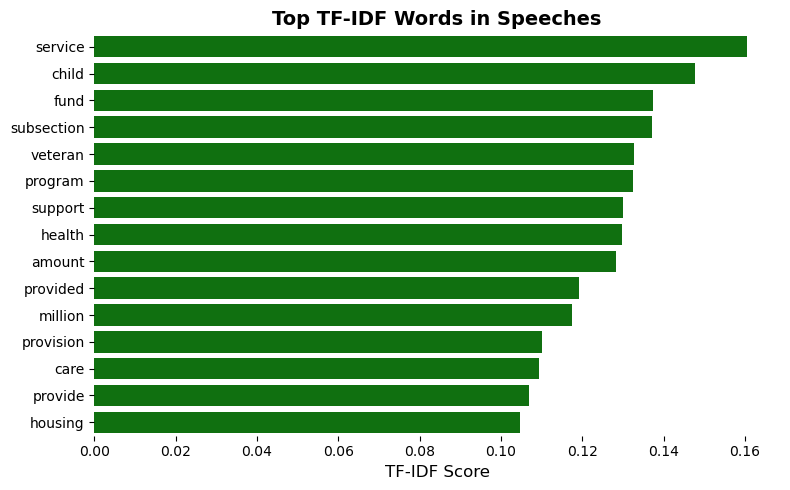

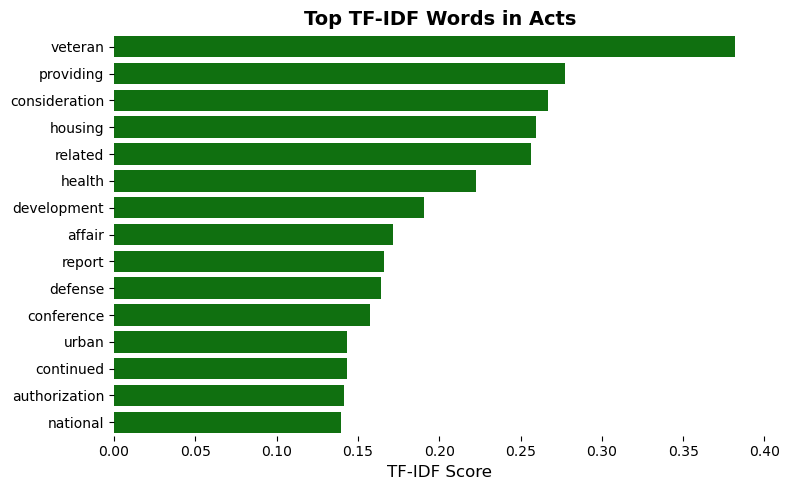

In [61]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_speech.head(15), 
    x="tfidf", y="token",
    color="green"
)
plt.title("Top TF-IDF Words in Speeches", fontsize=14, weight="bold")
plt.xlabel("TF-IDF Score", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_act.head(15),
    x="tfidf", y="token",
    color ='green'  
)
plt.title("Top TF-IDF Words in Acts", fontsize=14, weight="bold")
plt.xlabel("TF-IDF Score", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()

In [62]:
party_docs = (
    tokens_speech.groupby("Party")["tokens_speech_text"]
    .apply(lambda s: " ".join(s.astype(str).tolist()))
    .reset_index(name="text"))
vec = TfidfVectorizer(
    analyzer="word",
    token_pattern=r"(?u)\b\w+\b",
    lowercase=False,
    ngram_range=(1,1) 
)

X = vec.fit_transform(party_docs["text"])
vocab = np.array(vec.get_feature_names_out())

def for_party(idx, k=30):
    scores = np.asarray(X[idx].todense()).ravel()
    ix = scores.argsort()[::-1][:k]
    return pd.DataFrame({"token": vocab[ix], "tfidf": scores[ix]})

party_names = party_docs["Party"].tolist()
top_by_party = {party_names[i]: for_party(i, 30) for i in range(len(party_names))}

top_by_party["Democrat"].head(15), top_by_party["Republican"].head(15)

(         token     tfidf
 0        child  0.182278
 1      service  0.178089
 2       health  0.165153
 3      veteran  0.157038
 4      support  0.156131
 5         fund  0.151966
 6       family  0.132525
 7         care  0.126570
 8         work  0.119148
 9      housing  0.117656
 10     senator  0.114398
 11    national  0.113574
 12  subsection  0.108645
 13     million  0.107715
 14     program  0.103836,
          token     tfidf
 0      service  0.183659
 1   subsection  0.178574
 2         fund  0.157594
 3        child  0.147799
 4      veteran  0.140176
 5      support  0.134051
 6       health  0.123703
 7       amount  0.120236
 8   government  0.119966
 9         care  0.118172
 10     housing  0.117591
 11    national  0.109632
 12     program  0.108215
 13        work  0.101753
 14      report  0.101078)

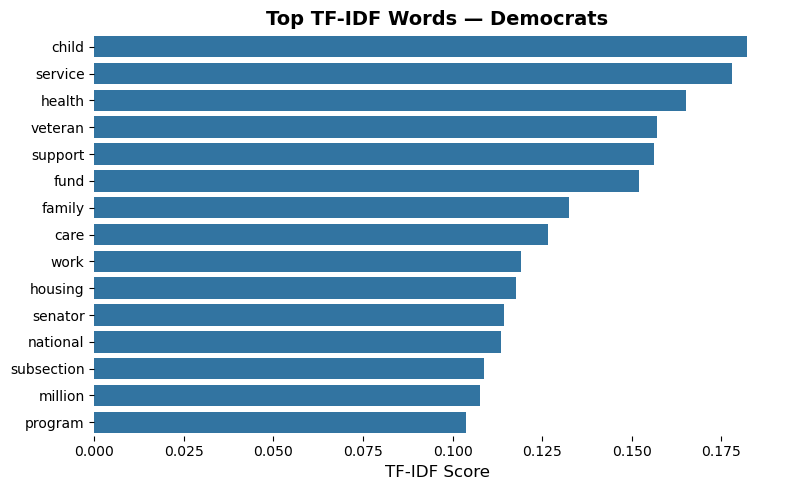

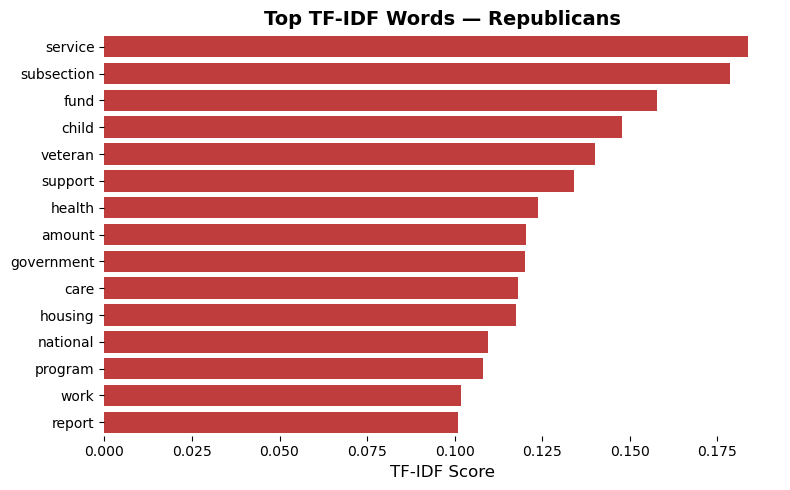

In [63]:
#dmes
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_by_party["Democrat"].sort_values("tfidf", ascending=False).head(15),
    x="tfidf", y="token",
    color="#1f77b4")
plt.title("Top TF-IDF Words — Democrats", fontsize=14, weight="bold")
plt.xlabel("TF-IDF Score", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_by_party["Republican"].sort_values("tfidf", ascending=False).head(15),
    x="tfidf", y="token",
    color="#d62728")
plt.title("Top TF-IDF Words — Republicans", fontsize=14, weight="bold")
plt.xlabel("TF-IDF Score", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
plt.show()


In [64]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

docs_title = (
    tokens_speech.groupby("Title", sort=False)["tokens_speech_text"]
    .apply(lambda s: " ".join(s.astype(str)))
    .reset_index(name="text")
)
(docs_title).head(10)
docs = docs_title["text"].astype(str).tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model = UMAP(
    n_neighbors=25,   
    n_components=5,
    min_dist=0.1, 
      metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=8,             
    min_samples=1,                   
    cluster_selection_epsilon=0.05,  
    prediction_data=True
)

vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    stop_words="english",
    token_pattern=r"(?u)\b[A-Za-z][A-Za-z]+\b"
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)
topics, probs = topic_model.fit_transform(docs)

topic_model = topic_model.reduce_topics(docs, nr_topics=20)
docs_title["topic"] = topics
topic_info = topic_model.get_topic_info()
n_outliers = (docs_title["topic"] == -1).sum()

2025-11-07 19:55:39,511 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

2025-11-07 19:55:48,941 - BERTopic - Embedding - Completed ✓
2025-11-07 19:55:48,941 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-07 19:55:50,876 - BERTopic - Dimensionality - Completed ✓
2025-11-07 19:55:50,876 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-07 19:55:50,959 - BERTopic - Cluster - Completed ✓
2025-11-07 19:55:50,960 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-07 19:55:55,299 - BERTopic - Representation - Completed ✓
2025-11-07 19:55:59,151 - BERTopic - Topic reduction - Reducing number of topics
2025-11-07 19:55:59,154 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-07 19:56:02,917 - BERTopic - Representation - Completed ✓
2025-11-07 19:56:02,919 - BERTopic - Topic reduction - Reduced number of topics from 52 to 20


In [65]:
topic_info['Representation'].value_counts

<bound method IndexOpsMixin.value_counts of 0     [health, child, service, work, fund, care, pla...
1     [veteran, fund, service, housing, support, def...
2     [child, violence, trafficking, victim, abuse, ...
3     [authorized meet, ask, meet, pre html, html, c...
4     [reconsider, ask, laid, reconsider laid, laid ...
5     [pre html, html, pre, republican, tax, care, b...
6     [ask revise, revise extend, revise, extend, as...
7     [rollcall, voted, present voted, pre html, htm...
8     [iraq, senator, woman, mikulski, health, troop...
9     [objection, objection pre, html ask, objection...
10    [health, school, hiv, service, grant, food, ai...
11    [water, coal, forest, pfas, epa, ash, environm...
12    [tabular, include tabular, ask revise, extrane...
13    [objection recessed, reassembled called, reass...
14    [cosponsor, cosponsor ask, ask, removed, ask w...
15    [privilege, granted privilege, granted, ask, p...
16    [debt, stood, trillion, trillion billion, ago ...
17  

In [66]:
docs_title["topic"].value_counts().sort_index()

topic
-1     240
 0     149
 1      72
 2      67
 3      53
 4      48
 5      40
 6      33
 7      32
 8      30
 9      25
 10     24
 11     24
 12     22
 13     22
 14     22
 15     20
 16     20
 17     19
 18     16
 19     16
 20     15
 21     15
 22     15
 23     14
 24     14
 25     14
 26     13
 27     13
 28     12
 29     12
 30     12
 31     12
 32     11
 33     11
 34     11
 35     11
 36     11
 37     11
 38     10
 39     10
 40     10
 41     10
 42     10
 43     10
 44     10
 45      9
 46      9
 47      9
 48      8
 49      8
 50      8
Name: count, dtype: int64